In [173]:
import numpy as np
import pandas as pd
import seaborn as sns
import string
import matplotlib.pyplot as plt
import math
import warnings
from sklearn.model_selection import train_test_split

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

warnings.filterwarnings('ignore')

In [174]:
CLASS_NAMES = ['T-shirt/top', 
               'Trouser', 
               'Pullover', 
               'Dress', 
               'Coat', 
               'Sandal',      
               'Shirt',   
               'Sneaker',  
               'Bag',   
               'Ankle boot']

In [175]:
def one_hot(y, n_labels):
    mat = np.zeros((len(y), n_labels))
    for i, val in enumerate(y):
        mat[i, val] = 1
    return mat

In [176]:
def L2_reg(lambda_, w1, w2):
    return (lambda_ / 2.0) * (np.sum(w1 ** 2) + np.sum(w2 ** 2))

def L1_reg(lambda_, w1, w2):
    return (lambda_ / 2.0) * (np.abs(w1).sum() + np.abs(w2).sum())

def cross_entropy(outputs, y_target):
    return -np.sum(np.log(outputs) * y_target, axis=1)

In [177]:
def plot_error(model):
    plt.plot(range(len(model.error_)), model.error_)
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.show()

In [178]:
def plot_accuracy(model):    
    plt.plot(range(len(model.score_)), model.score_)
    plt.ylabel('Score')
    plt.xlabel('Epochs')
    plt.show()

In [179]:
def plot_image(i, predictions_array, true_labels, images):
    predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel("{} ({})".format(CLASS_NAMES[predicted_label], CLASS_NAMES[true_label]), color=color)
    color_map = 'Greens' if predicted_label == true_label else 'Reds'
    plt.imshow(img.reshape(28,28), cmap=color_map )


def plot_image_grid(X_test, y_test, y_hat, num_rows=10, num_cols=5):
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, y_hat, y_test, X_test)

In [180]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

X = data_train.iloc[:,1:785].values
y = data_train.iloc[:,0].values

N_FEATURES = 28 * 28 # 28x28 pixels for the images
N_CLASSES = 10

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_train.shape

(44800, 784)

In [182]:
#normalization 
X_train = (X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train))
X_test = (X_test-np.min(X_test))/(np.max(X_test)-np.min(X_test))

In [184]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [185]:
def sigmoid_prime(z):
    sg = sigmoid(z)
    return sg * (1 - sg)

In [186]:
def softmax(z):
    return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

In [187]:
def one_hot(y, n_labels):
    mat = np.zeros((len(y), n_labels))
    for i, val in enumerate(y):
        mat[i, val] = 1
    return mat

## Part 1 - Visualize the Data

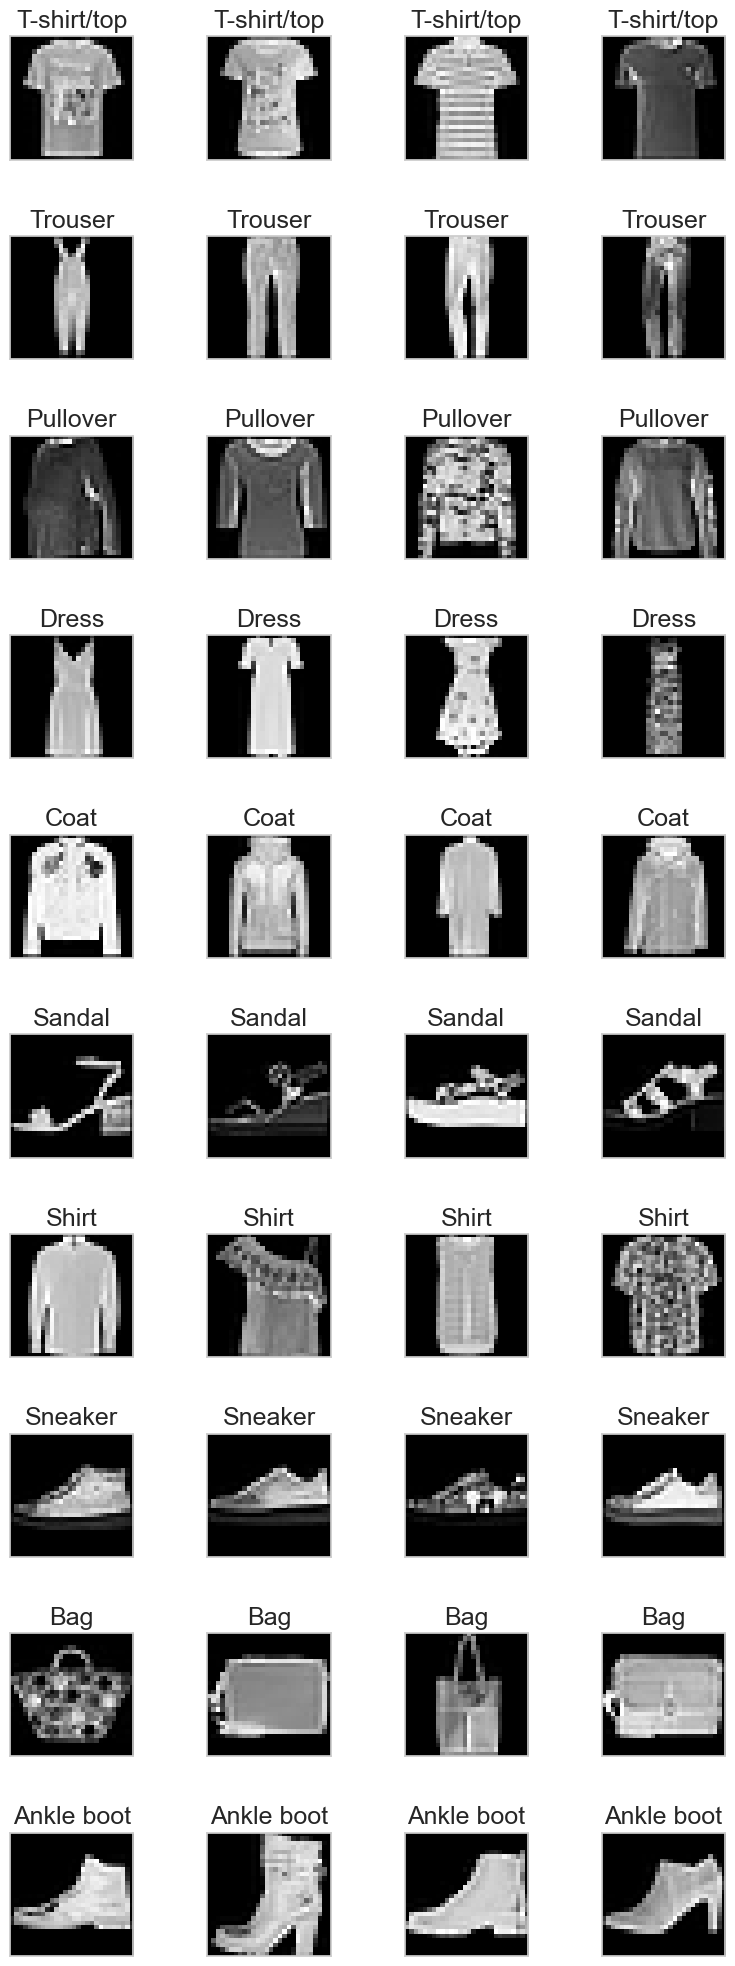

In [183]:
# Creating an empty dictionary and initialising it with empty list that can hold image tensors for each of 
# the 10 classes(from class 0 to class 9): 
count_dict = {}
position_dict = {}

for i in range(10):
    position_dict[i] = []
    count_dict[i]  = 0   

# Creating an iter variable that iterates through the train_data
iterator_img = iter(X_train)
iterator_lab = iter(y_train)
image = next(iterator_img)
label = next(iterator_lab)

# Appending atleast 10 image tensors for each of the 10 classes: 
while True in (np.array(list(count_dict.values())) < 10):
    count_dict[label] += 1
    position_dict[label].append(image)
    image = next(iterator_img)
    label = next(iterator_lab)  

# Printing the list of image tensors stored in the position_dict: 
plt.figure(figsize = (20, 20))

for i in range(10):
    j = 0
    while(j<4):
        plt.subplot(10,10,(i*10+j+1))
        plt.xticks([])
        plt.yticks([])
        image = image*0.5 + 0.5
        plt.imshow(position_dict[i][j].reshape((28, 28)), cmap = "gray")
        plt.title(CLASS_NAMES[i])
        j+=1
        
plt.tight_layout(h_pad=2)
plt.show()


## Part 2 - Logistic Regression Classifier

In [228]:
class LogisticRegression:    
    def __init__ (self, learning_rate=0.2, batch_size=3000, lmbda=1000, epochs=1):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.w = np.random.uniform(-1.0, 1.0, size=(784, 10)) 
        self.b = np.zeros(10)
        self.batch_size = batch_size
        self.lmbda = lmbda
        
    def loss(self, y, y_pred):
        loss = (np.sum(np.sum(np.multiply(y, np.log(y_pred)), axis=1)) / y_pred.size) 
        L2 = self.lmbda * np.sum(np.square(self.w)) / (2 * y_pred.size) 
        return loss + L2
    
    def accuracy(self, y, y_pred):
        return np.sum(y_pred==y) / len(y)
    
    def predict(self, X):
        return softmax(np.dot(X, self.w))
    
    def predict_proba(self, X): 
        return np.argmax(softmax(np.dot(X, self.w)), axis=1)
    
    def fit(self, X_train, y_train, X_test, y_test):    
        self.train_loss = []
        self.valid_loss = []
        self.train_accuracy = []
        self.valid_accuracy = []
        y_one_hot_valid = one_hot(y_test,10)
        for i in range(1, self.epochs): 
            for t in range(0, y_train.size, self.batch_size):
                X_train_mini = X_train[:, t:(t+self.batch_size)]
                y_train_mini = y_train[t:(t+self.batch_size)]
                y_one_hot_train = one_hot(y_train_mini,10)

                #forward
                y_pred_train = softmax(X_train_mini.T.dot(self.w) + self.b)
                y_pred_valid = softmax(X_test.T.dot(self.w))
                
                #backward
                dw = -np.dot(X_train_mini,(y_one_hot_train - y_pred_train)) / self.batch_size + (self.lmbda / y_pred_train.size * self.w)
                db = - np.sum(y_one_hot_train - y_pred_train) / self.batch_size
                
                #update weights
                self.w = self.w - self.learning_rate * dw
                self.b = self.b - self.learning_rate * db
            
            #train accuracy and loss
            self.train_loss.append(self.loss(y_one_hot_train, y_pred_train))
            self.train_accuracy.append(self.accuracy(y_train_mini, np.argmax(y_pred_train, axis=1)))
                      
            #validation accuracy and loss
            self.valid_loss.append(self.loss(y_one_hot_valid, y_pred_valid))
            self.valid_accuracy.append(self.accuracy(y_test, np.argmax(y_pred_valid, axis=1)))
        return self

In [242]:
model_1 = LogisticRegression(epochs=50, learning_rate=0.05, batch_size=1000, lmbda=10).fit(X_train.T, y_train.T, X_test.T, y_test.T)

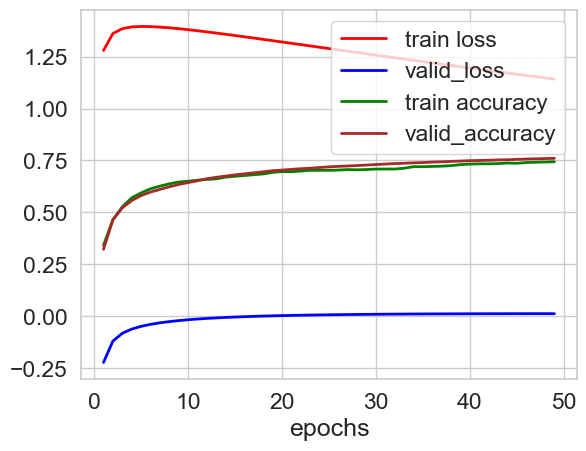

In [243]:
x = range(1, model_1.epochs);
legend = ["train loss", "valid_loss", "train accuracy", "valid_accuracy"]

plt.plot(x, model_1.train_loss, color="red", linewidth=2.0)
plt.plot(x, model_1.valid_loss, color="blue", linewidth=2.0)
plt.plot(x, model_1.train_accuracy, color="green", linewidth=2.0)
plt.plot(x, model_1.valid_accuracy, color="brown", linewidth=2.0)
plt.xlabel("epochs")
plt.legend(legend, loc='best')

plt.show()

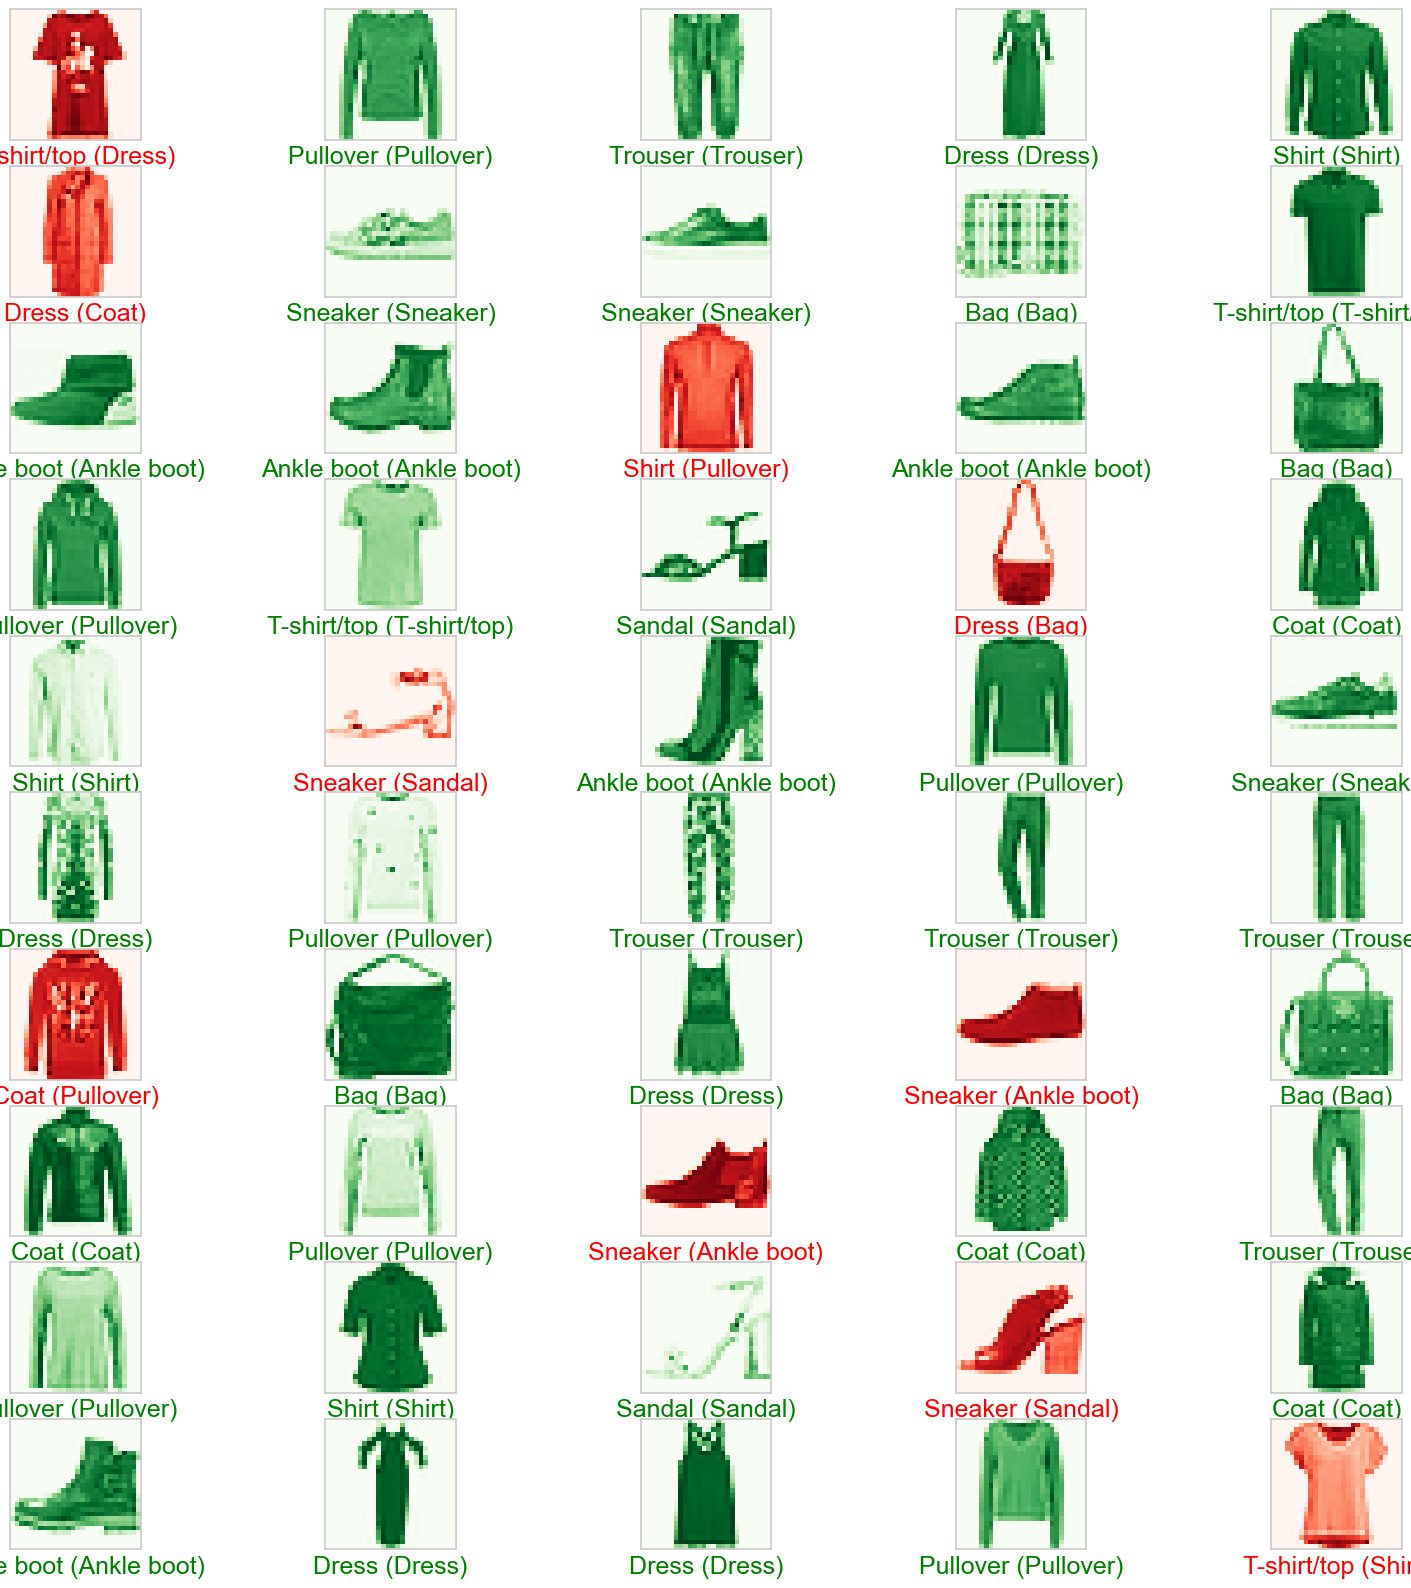

In [251]:
y_hat = model_1.predict(X_test)
plot_image_grid(X_test, y_test, y_hat)

In [252]:
data_test_LogisticRegression = pd.read_csv('test.csv')
data_test_LogisticRegression = data_test_LogisticRegression.iloc[:,0:785].values

predi=model_1.predict_proba(data_test_LogisticRegression)

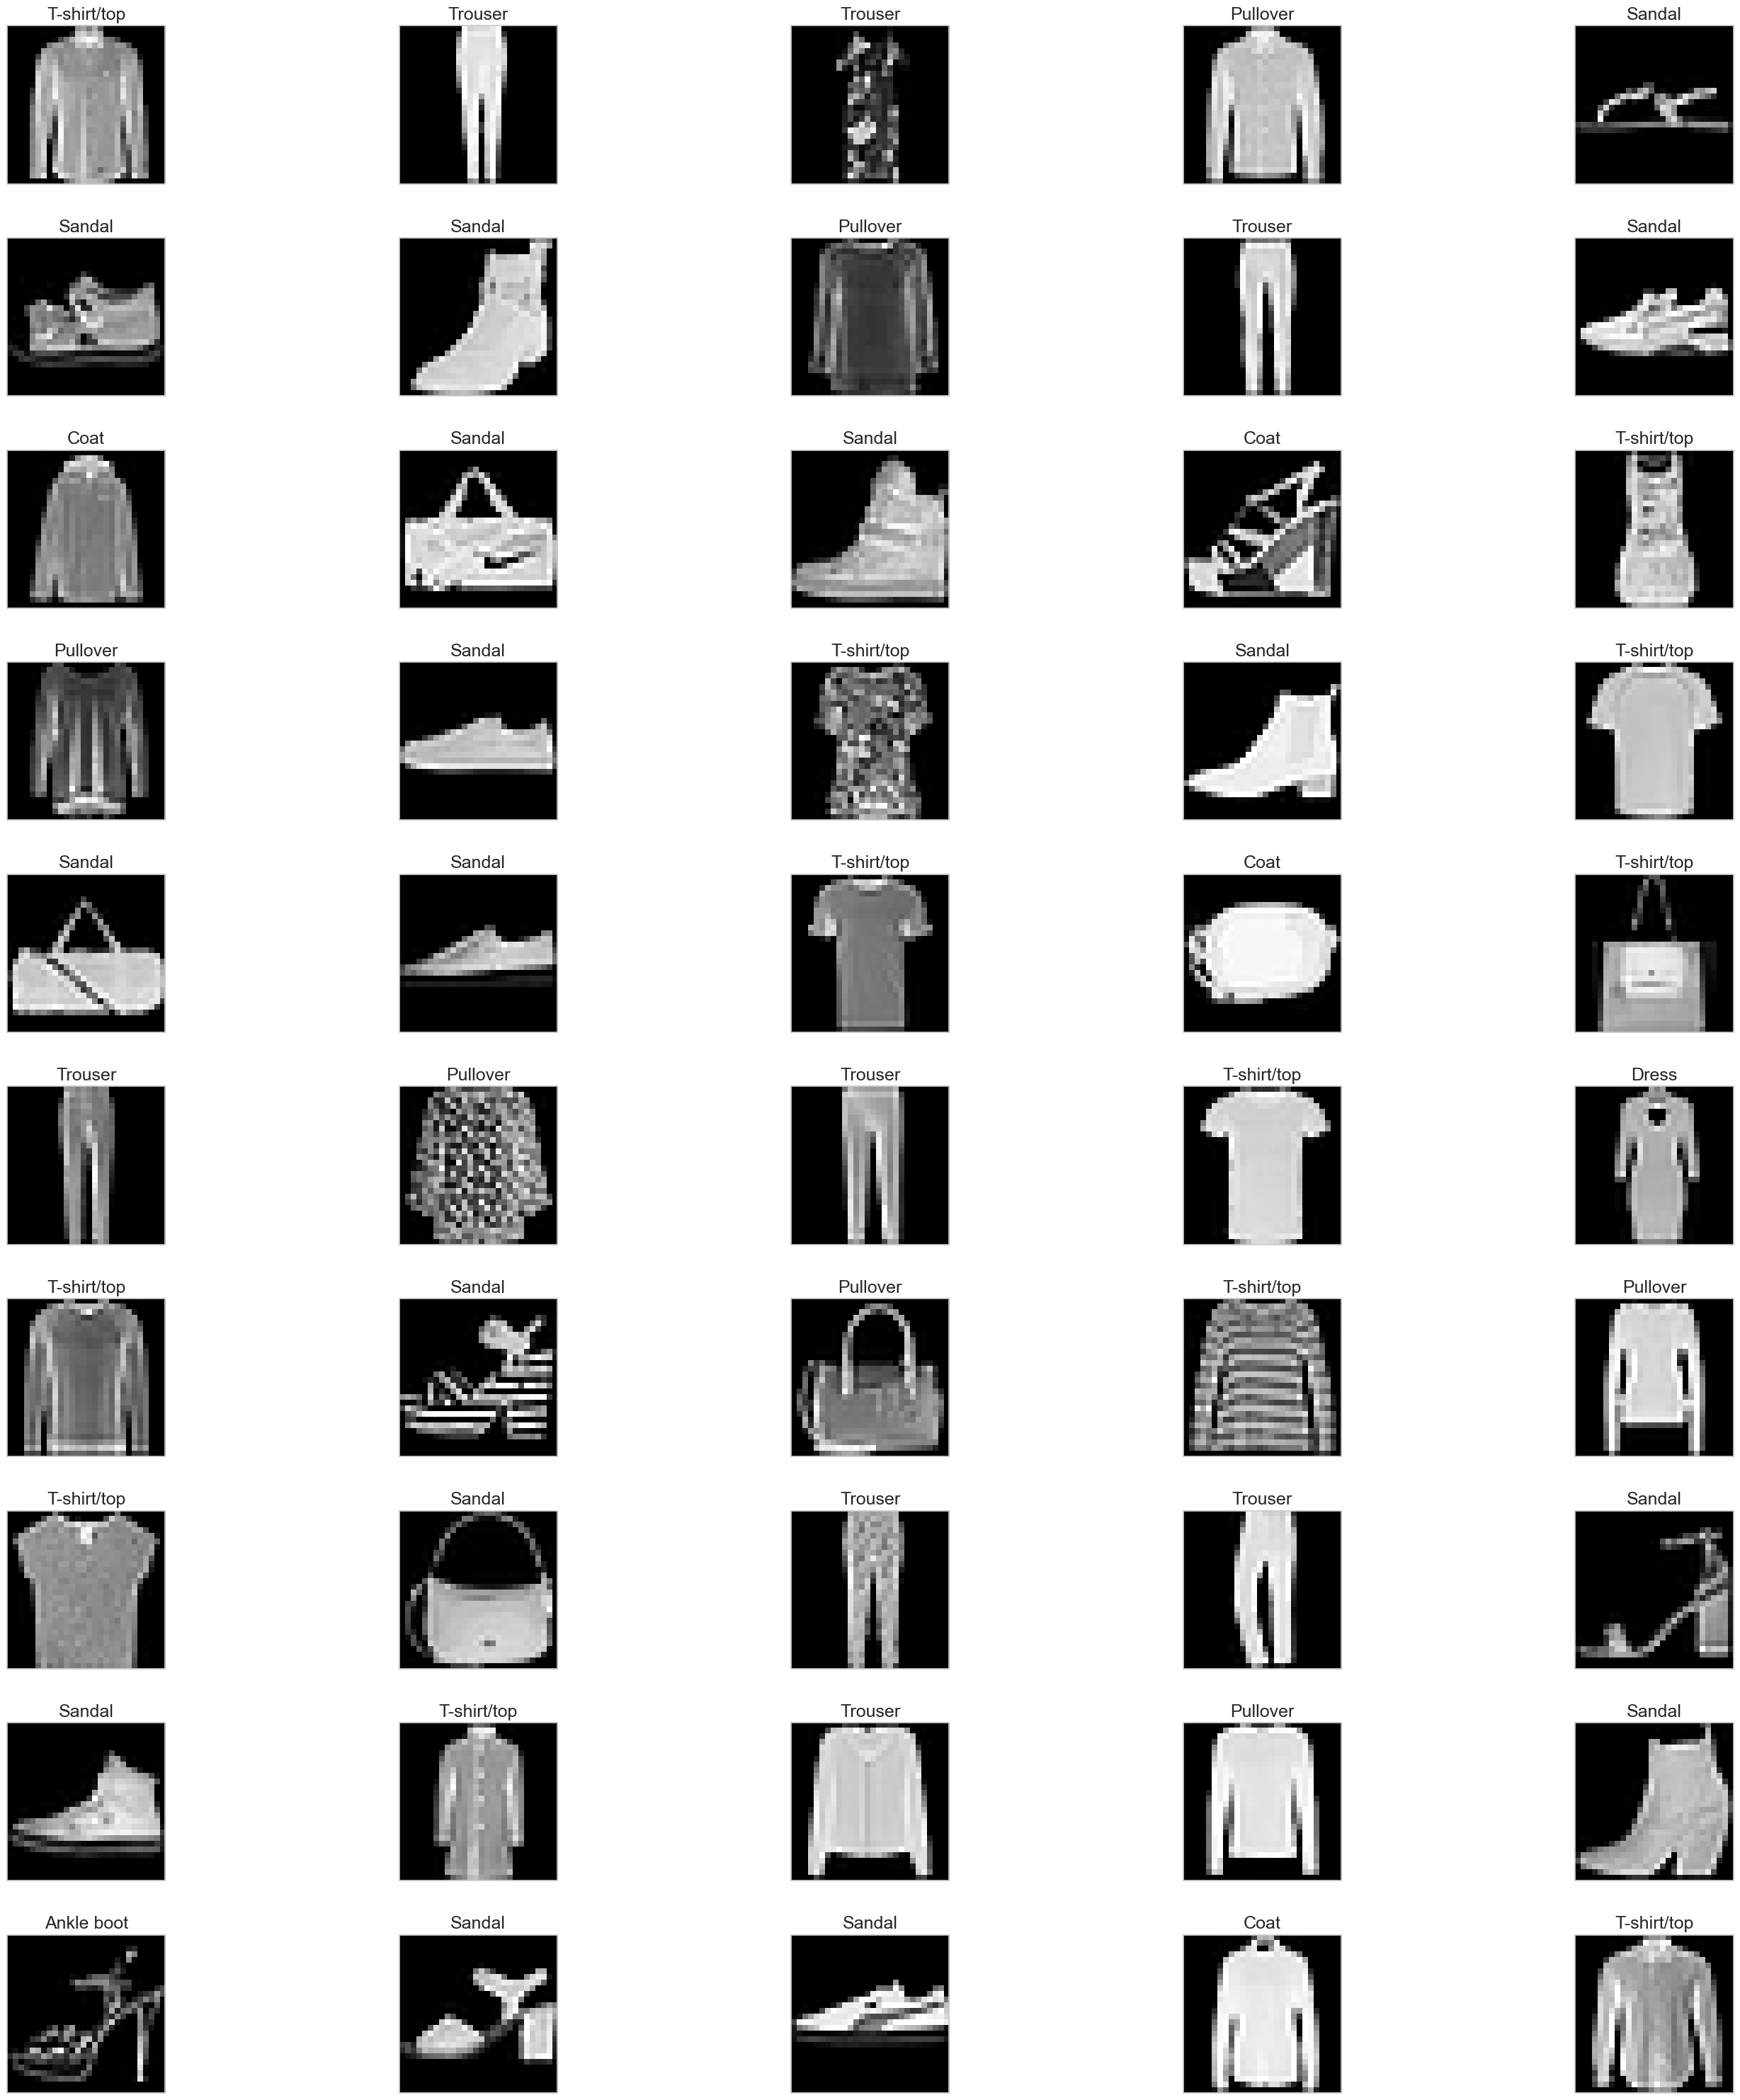

In [253]:
# Printing out a few images from the training data - just for visualisation:
iterator_img = iter(data_test_LogisticRegression)
iterator_lab = iter(predi)
image = next(iterator_img)
label = next(iterator_lab)

plt.figure(figsize = (30, 30))

for i in range(50):
    plt.subplot(10,5,i+1)
    plt.xticks([])
    plt.yticks([])
    image = image*0.5 + 0.5
    plt.imshow(image.reshape((28, 28)), cmap = "gray")
    plt.title(CLASS_NAMES[label])
    image = next(iterator_img)
    label = next(iterator_lab) 
    
plt.tight_layout(h_pad=2)
plt.show()

In [254]:
f = open('lr_pred.csv', 'w')
for index in predi:
    f.write(str(index) + '\n')

## Part 3 - Neural Network with One Hidden Layer

In [209]:
class NNClassifier:
    def __init__(self, n_classes, n_features, n_hidden_units=30, l1=0.0, l2=0.0, epochs=500, learning_rate=0.01, batch_size=1, keep_prob=0.5, random_seed=None):
        if random_seed:
            np.random.seed(random_seed)
        self.n_classes = n_classes
        self.n_features = n_features
        self.n_hidden_units = n_hidden_units
        self.w1, self.w2 = self._init_weights()
        self.b1, self.b2 = self._init_bias()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # dropout parameter
        self.keep_prob = keep_prob

    def _init_weights(self):
        w1 = np.random.uniform(-1.0, 1.0, size=(self.n_hidden_units, self.n_features))        
        w2 = np.random.uniform(-1.0, 1.0, size=(self.n_classes, self.n_hidden_units))
        return w1, w2
    
    def _init_bias(self):
        b1 = np.zeros(self.n_hidden_units)      
        b2 = np.zeros(self.n_classes) 
        return b1, b2
    
      
    def _forward(self, X):
        net_input = X.copy()     
        net_hidden = self.w1.dot(net_input.T)+ self.b1[:,None]

        act_hidden = sigmoid(net_hidden)
    
        #inverted dropout
        D1 = np.random.rand(act_hidden.shape[0], act_hidden.shape[1]) < self.keep_prob 
       
        act_hidden = np.multiply(act_hidden, D1)
        act_hidden /= self.keep_prob
               
        net_out = self.w2.dot(act_hidden)+ self.b2[:,None]
        act_out = sigmoid(net_out)
        return net_input, net_hidden, act_hidden, net_out, act_out
    
    def _backward(self, net_input, net_hidden, act_hidden, act_out, y):
        u = act_out.shape[0]
        sigma3 = act_out - y
        sigma2 = self.w2.T.dot(sigma3) * sigmoid_prime(net_hidden)
        
        db1 =  1 / u * np.sum(sigma3, axis=1)
        db2 =  1 / u *  np.sum(sigma2, axis=1)
        grad1 = 1 / u * sigma2.dot(net_input)
        grad2 = 1 / u * sigma3.dot(act_hidden.T)
        return grad1, grad2, db1, db2, u

    def _error(self, y, output):
        L1_term = L1_reg(self.l1, self.w1, self.w2)
        L2_term = L2_reg(self.l2, self.w1, self.w2)
        error = cross_entropy(output, y) + L1_term + L2_term
        return np.mean(error)
    
    def score(self, X, y):
        y_hat = self.predict(X)
        return np.sum(y == y_hat, axis=0) / float(X.shape[0])

    def _backprop_step(self, X, y):
        
        net_input, net_hidden, act_hidden, net_out, act_out = self._forward(X)
        y = y.T

        grad1, grad2, db1, db2, u = self._backward(net_input, net_hidden, act_hidden, act_out, y)
        
        # regularize
        grad1 += (self.l1 / u * self.w1 * (self.l1 + self.l2))
        grad2 += (self.l2 / u * self.w2 * (self.l1 + self.l2))
        
        error = self._error(y, act_out)
        return error, grad1, grad2, db1, db2

    def predict(self, X):
        Xt = X.copy()
        net_input, net_hidden, act_hidden, net_out, act_out = self._forward(Xt)
        return np.argmax(net_out.T, axis=1)
    
    def predict_proba(self, X):
        Xt = X.copy()
        net_input, net_hidden, act_hidden, net_out, act_out = self._forward(Xt)
        return softmax(act_out.T)

    def fit(self, X, y):
        self.error_ = []
        self.score_ = []
        X_data, y_data = X.copy(), y.copy()
        y_data_enc = one_hot(y_data, self.n_classes)
        
        X_mbs = np.array_split(X_data, int(len(X_data)/self.batch_size)+1)
        y_mbs = np.array_split(y_data_enc, int(len(y_data_enc)/self.batch_size)+1)
        
        for i in range(self.epochs):
            epoch_errors = []
            for Xi, yi in zip(X_mbs, y_mbs):
                # update weights
                error, grad1, grad2, db2, db1 = self._backprop_step(Xi, yi)
                epoch_errors.append(error/float(Xi.shape[0]))
                self.w1 -= (self.learning_rate * grad1)
                self.w2 -= (self.learning_rate * grad2)
                self.b1 -= (self.learning_rate * db1)
                self.b2 -= (self.learning_rate * db2)
            self.error_.append(np.mean(epoch_errors))
            self.score_.append(self.score(X_data,y_data))
        return self

In [210]:
nn = NNClassifier(
    n_classes=N_CLASSES, 
    n_features=N_FEATURES,
    n_hidden_units=50,
    l2=0.5,
    l1=0.0,
    epochs=500,
    learning_rate=0.01,
    batch_size=1000,
    keep_prob=0.9,
    random_seed=RANDOM_SEED
).fit(X_train, y_train);

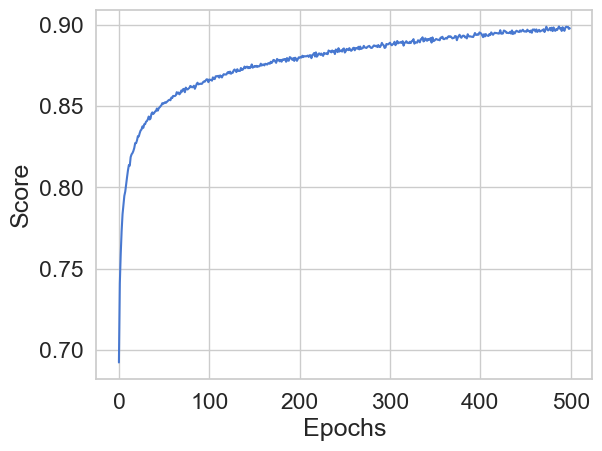

In [211]:
plot_accuracy(nn)

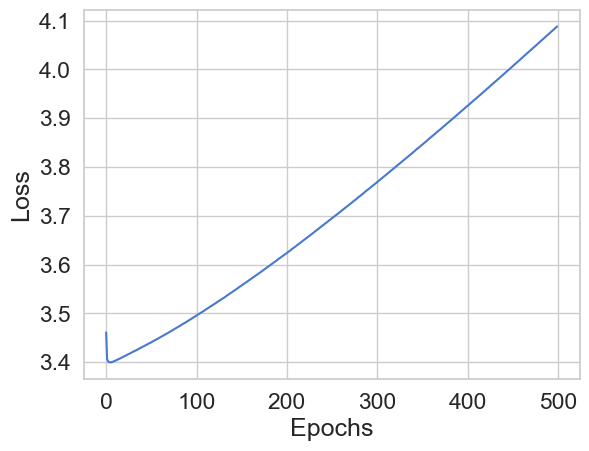

In [212]:
plot_error(nn)

In [255]:
print('Train Accuracy: %.2f%%' % (nn.score(X_train, y_train) * 100))
print('Test Accuracy: %.2f%%' % (nn.score(X_test, y_test) * 100))

Train Accuracy: 89.81%
Test Accuracy: 87.24%


In [256]:
y_hat = nn.predict_proba(X_test)

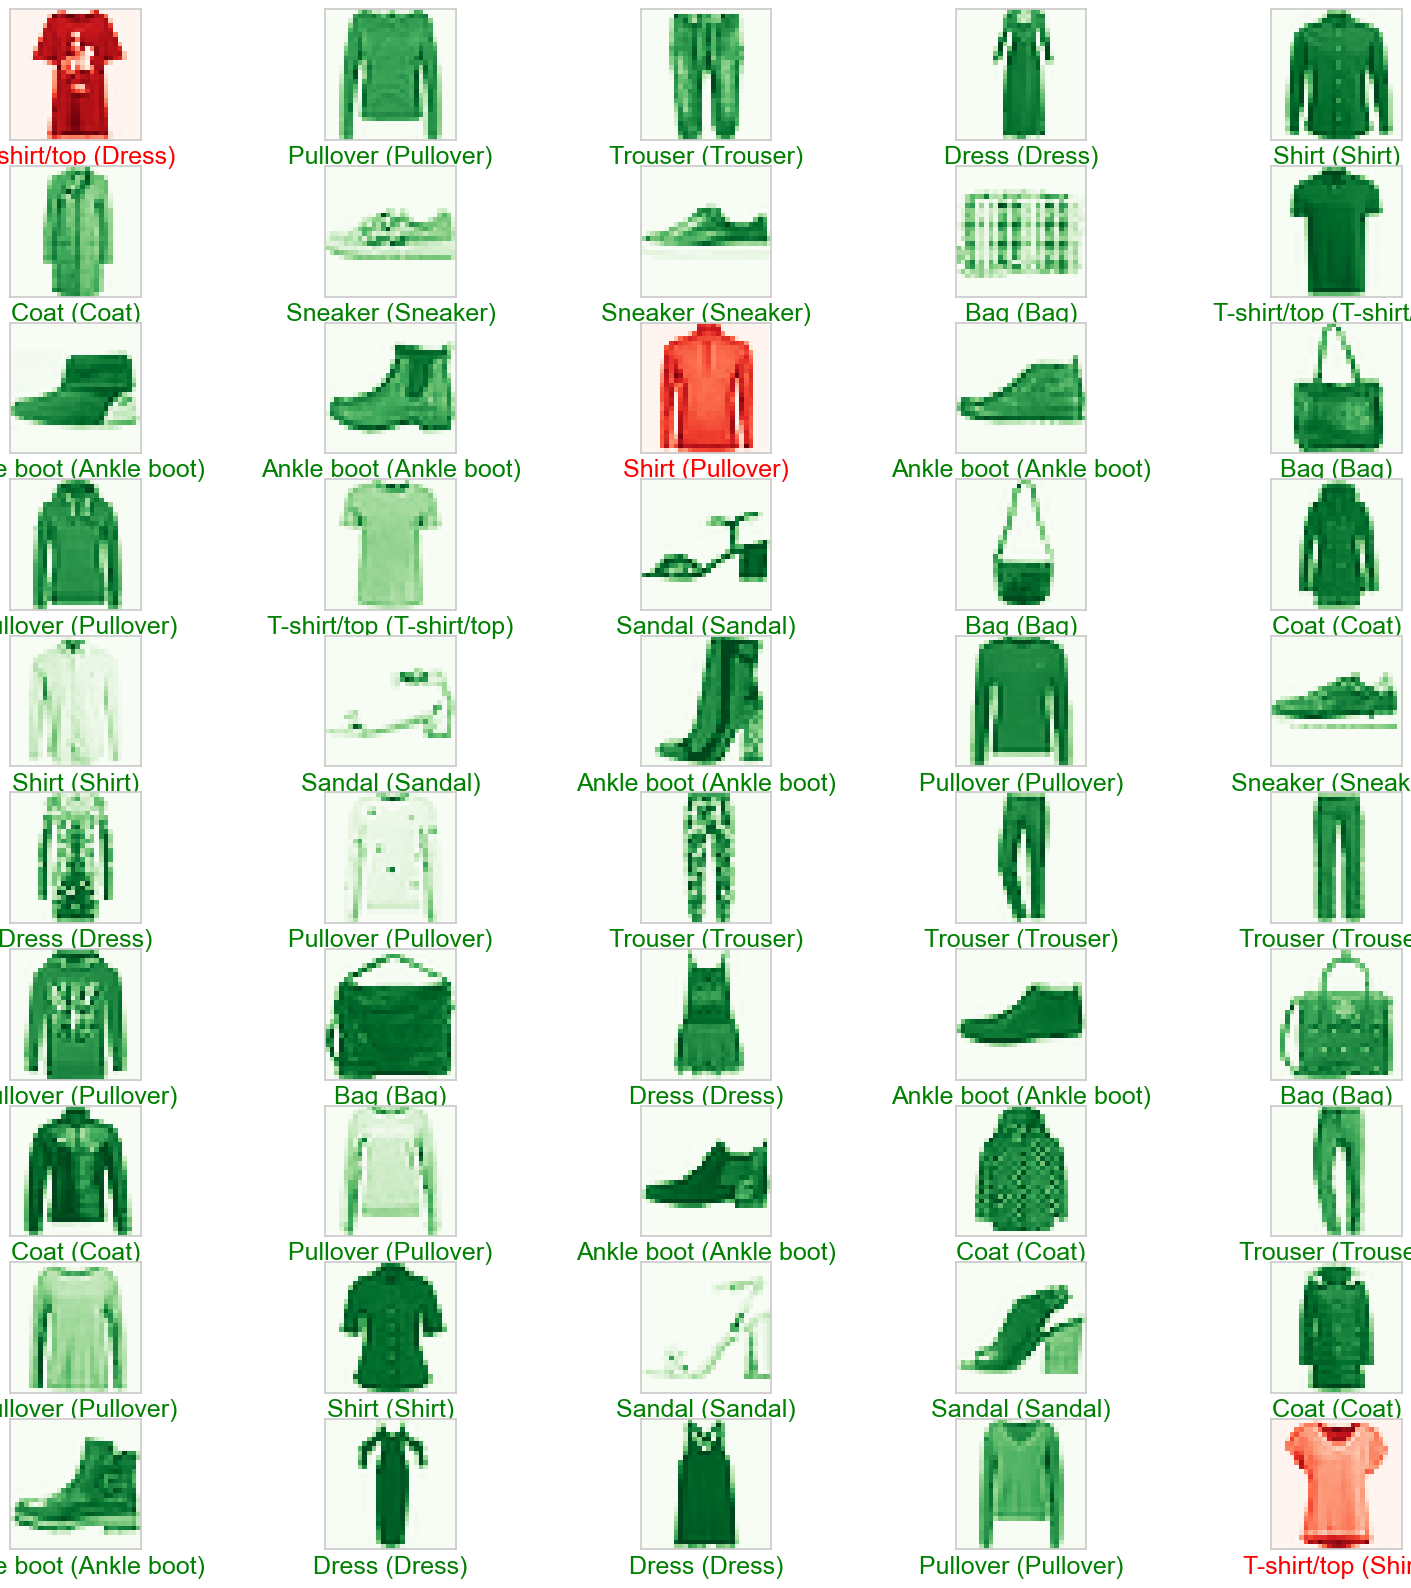

In [257]:
plot_image_grid(X_test, y_test, y_hat)

In [258]:
nn_valid = NNClassifier(
    n_classes=N_CLASSES, 
    n_features=N_FEATURES,
    n_hidden_units=50,
    l2=0.5,
    l1=0.0,
    epochs=10,
    learning_rate=0.001,
    batch_size=1000,
    random_seed=RANDOM_SEED
).fit(X_train, y_train);

In [259]:
data_test = pd.read_csv('test.csv')
data_test = data_test.iloc[:,0:785].values

predi=nn.predict(data_test)

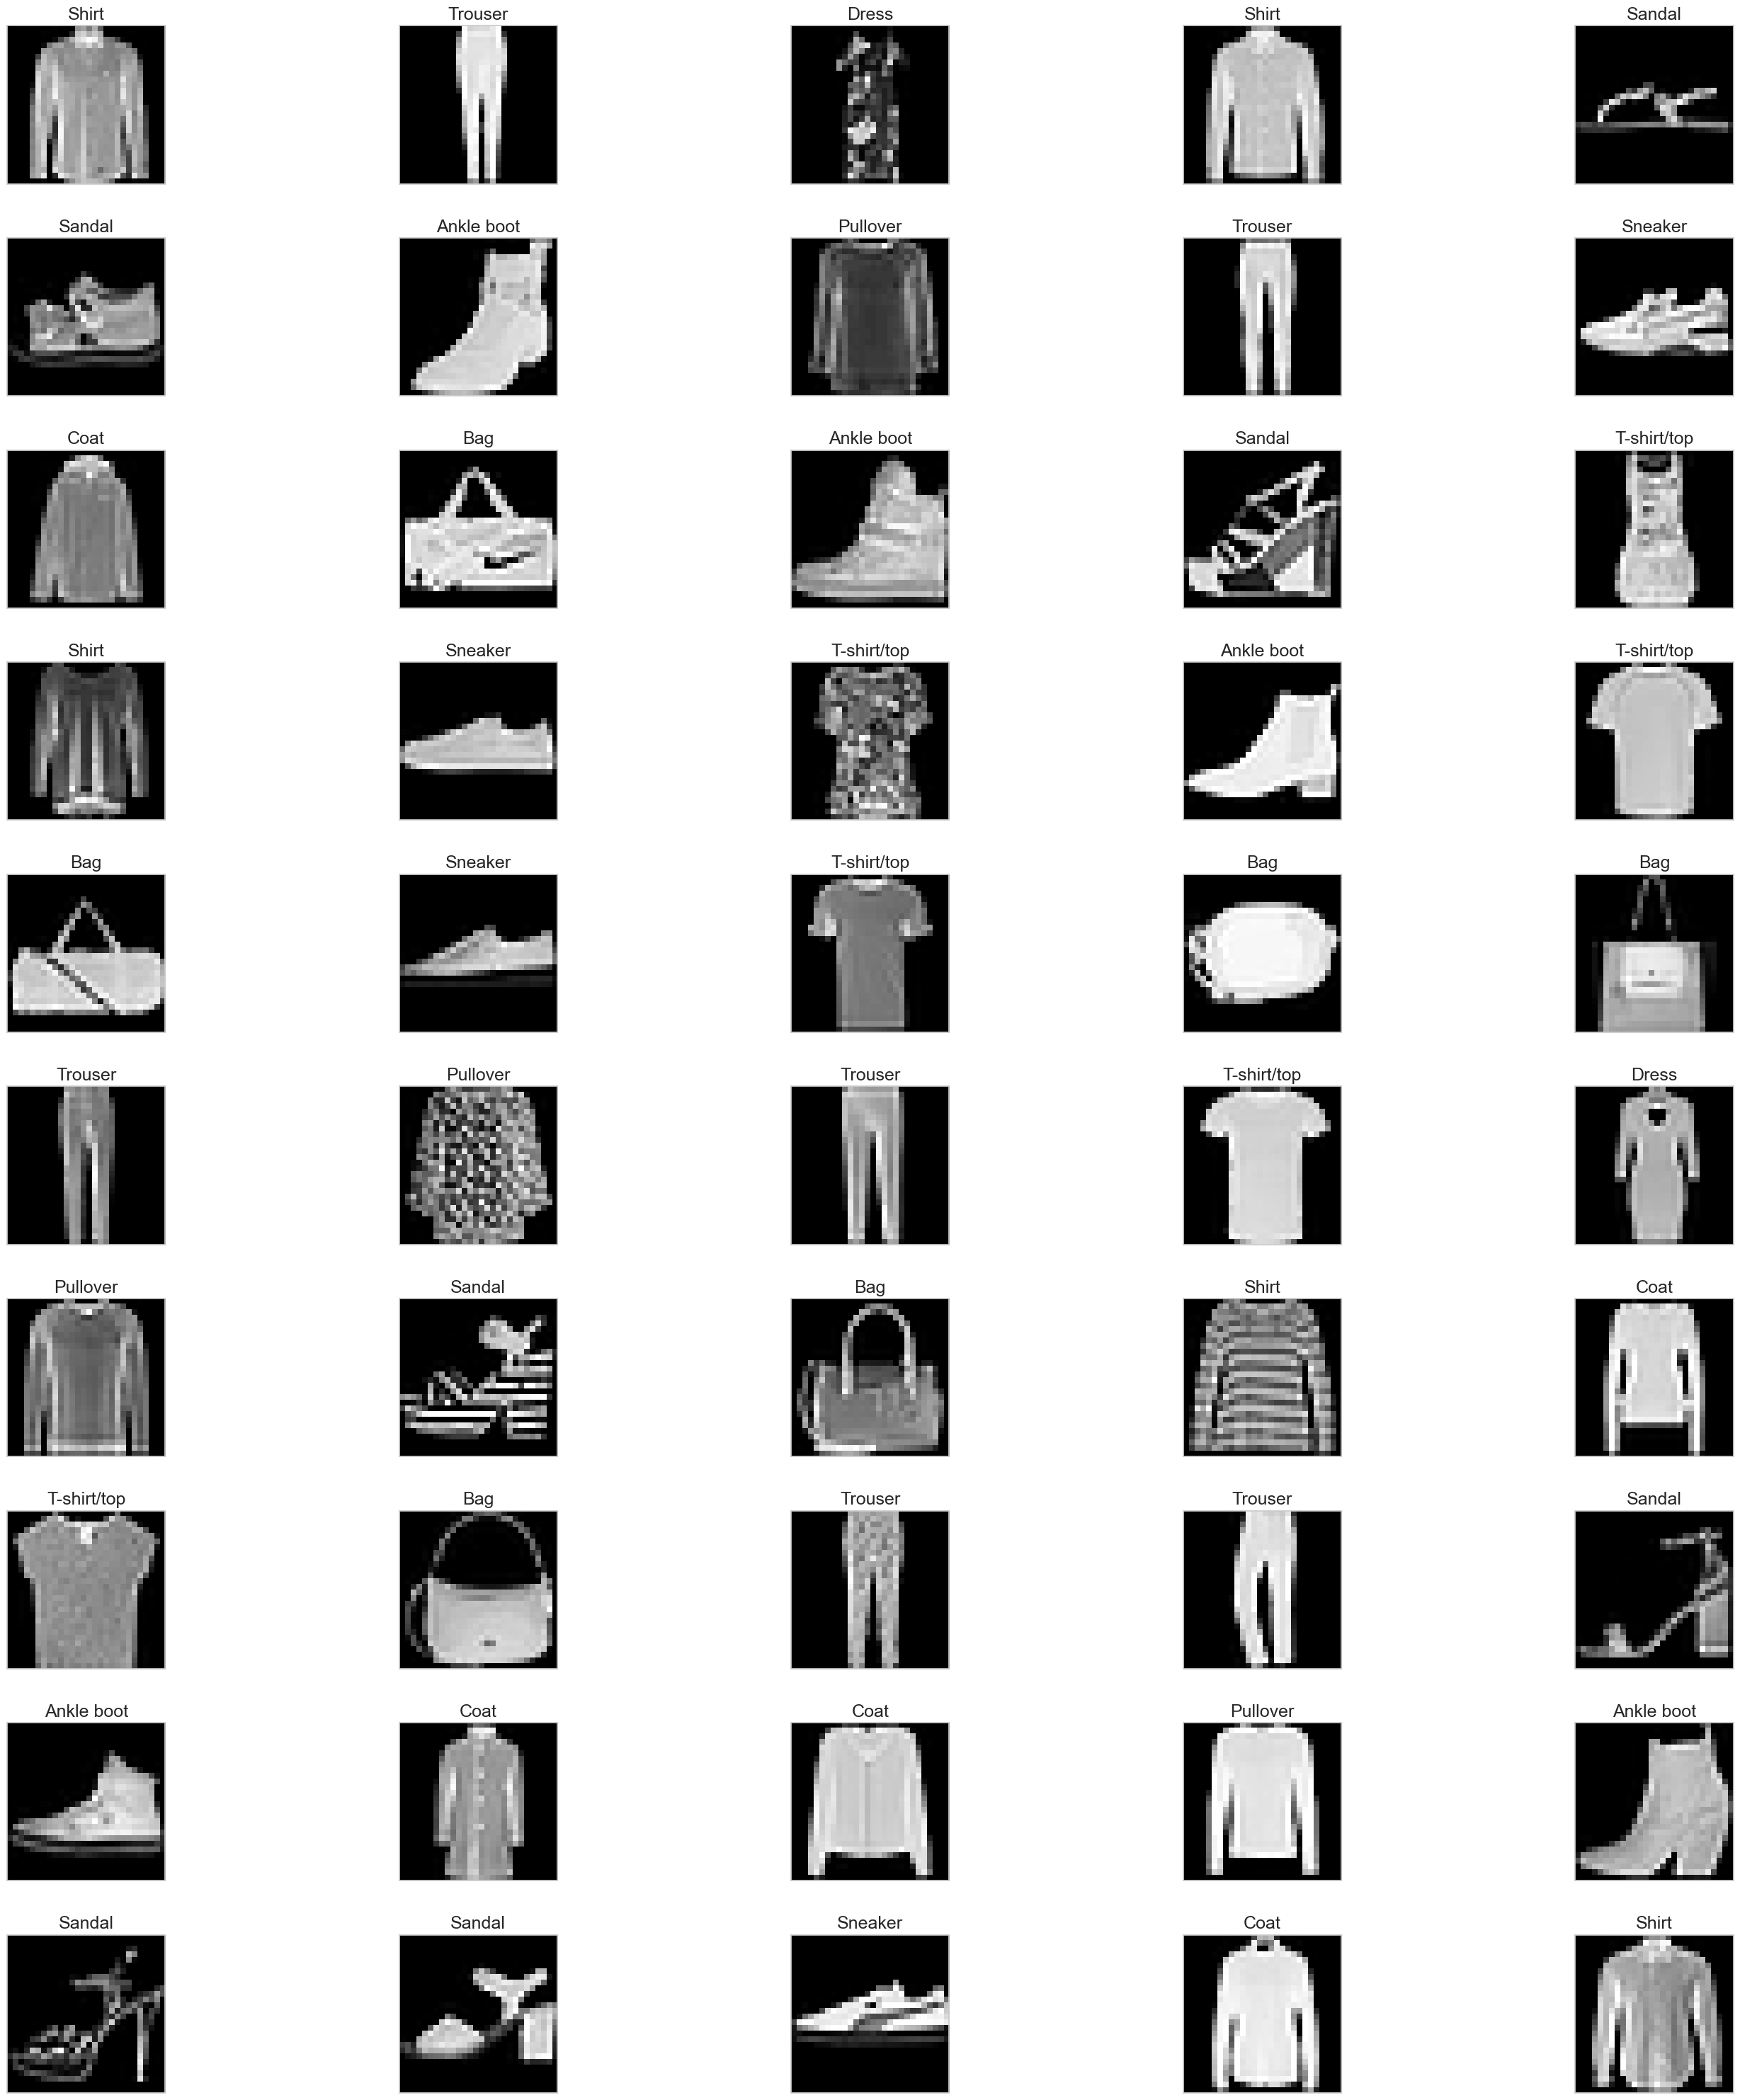

In [260]:
# Printing out a few images from the training data - just for visualisation:
iterator_img = iter(data_test)
iterator_lab = iter(predi)
image = next(iterator_img)
label = next(iterator_lab)

plt.figure(figsize = (30, 30))

for i in range(50):
    plt.subplot(10,5,i+1)
    plt.xticks([])
    plt.yticks([])
    image = image*0.5 + 0.5
    plt.imshow(image.reshape((28, 28)), cmap = "gray")
    plt.title(CLASS_NAMES[label])
    image = next(iterator_img)
    label = next(iterator_lab) 
    
plt.tight_layout(h_pad=2)
plt.show()

In [261]:
f = open('NN_pred.csv', 'w')
for index in predi:
    f.write(str(index) + '\n')

## Experiment

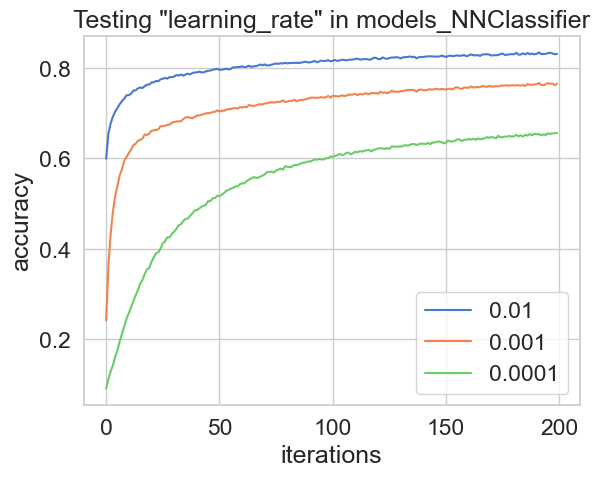

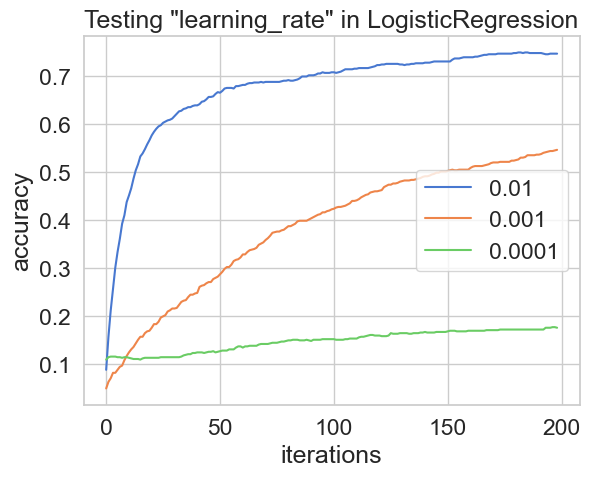

In [220]:
learning_rates = [0.01, 0.001, 0.0001]
legend = ["0.01", "0.001", "0.0001"]

models_NNClassifier = {}
for i in learning_rates:
    models_NNClassifier[str(i)] = NNClassifier(n_classes=N_CLASSES, n_features=N_FEATURES, n_hidden_units=50, l2=0.5, l1=0.0, epochs=200, learning_rate=i, batch_size=1000, random_seed=RANDOM_SEED).fit(scale(X_train.astype(np.float64)), y_train)
    plt.plot(range(len(models_NNClassifier[str(i)].score_)), models_NNClassifier[str(i)].score_)
plt.legend(legend, loc='best')
plt.title('Testing "learning_rate" in models_NNClassifier')
plt.ylabel('accuracy')
plt.xlabel('iterations')
plt.show()

models_LogisticRegression = {}
for i in learning_rates:
    models_LogisticRegression[str(i)] = LogisticRegression(epochs=200, learning_rate=i, batch_size=1000, lmbda=10).fit(X_train.T, y_train.T, X_test.T, y_test.T)
    plt.plot(range(len(models_LogisticRegression[str(i)].train_accuracy)),models_LogisticRegression[str(i)].train_accuracy)   
plt.legend(legend, loc='best')
plt.title('Testing "learning_rate" in LogisticRegression')
plt.ylabel('accuracy')
plt.xlabel('iterations')
plt.show()


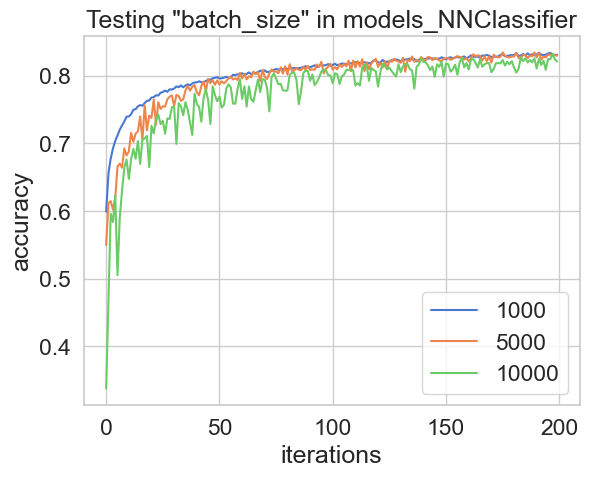

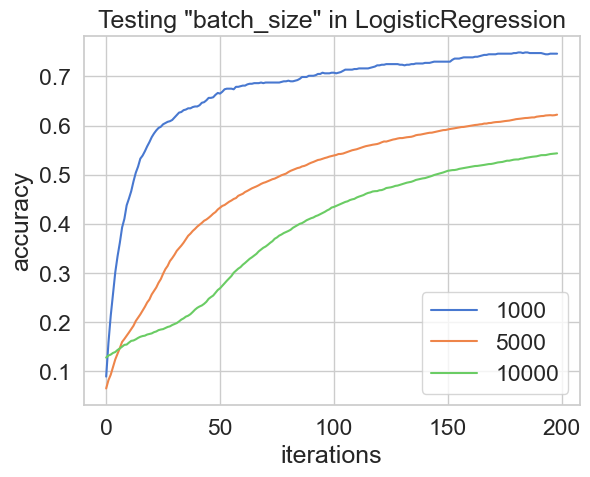

In [221]:
batch_size = [1000, 5000, 10000]
legend = ["1000", "5000", "10000"]

models_NNClassifier = {}
for i in batch_size:
    models_NNClassifier[str(i)] = NNClassifier(n_classes=N_CLASSES, n_features=N_FEATURES,  n_hidden_units=50, l2=0.5, l1=0.0, epochs=200, learning_rate=0.01,batch_size=i, random_seed=RANDOM_SEED).fit(scale(X_train.astype(np.float64)), y_train)
    plt.plot(range(len(models_NNClassifier[str(i)].score_)), models_NNClassifier[str(i)].score_)
plt.legend(legend, loc='best')
plt.title('Testing "batch_size" in models_NNClassifier')
plt.ylabel('accuracy')
plt.xlabel('iterations')
plt.show()

models_LogisticRegression = {}
for i in batch_size:
    models_LogisticRegression[str(i)] = LogisticRegression(epochs=200, learning_rate=0.01, batch_size=i, lmbda=10).fit(X_train.T, y_train.T, X_test.T, y_test.T)
    plt.plot(range(len(models_LogisticRegression[str(i)].train_accuracy)),models_LogisticRegression[str(i)].train_accuracy)   
plt.legend(legend, loc='best')
plt.title('Testing "batch_size" in LogisticRegression')
plt.ylabel('accuracy')
plt.xlabel('iterations')
plt.show()


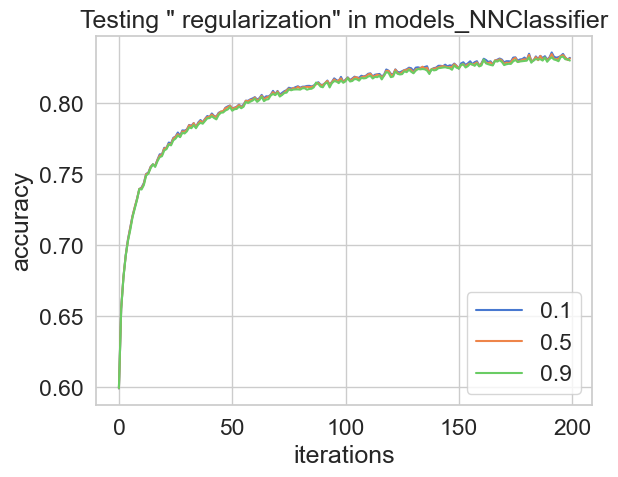

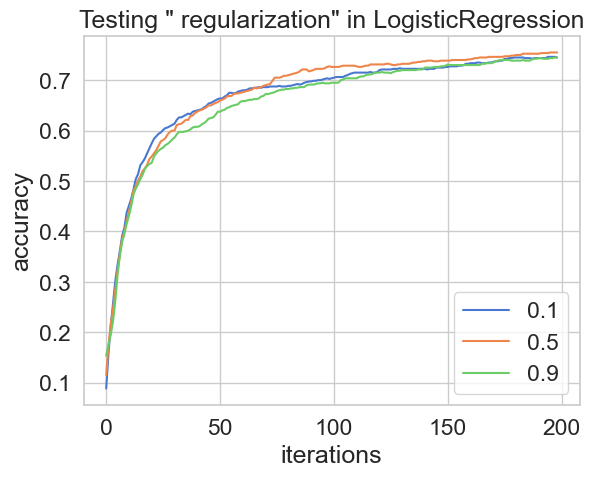

In [222]:
regularization = [0.1, 0.5, 0.9]
legend = ["0.1", "0.5", "0.9"]

models_NNClassifier = {}
for i in regularization:
    models_NNClassifier[str(i)] = NNClassifier(n_classes=N_CLASSES, n_features=N_FEATURES,  n_hidden_units=50, l2=i, l1=0.0, epochs=200, learning_rate=0.01,batch_size=1000, random_seed=RANDOM_SEED).fit(X_train, y_train)
    plt.plot(range(len(models_NNClassifier[str(i)].score_)), models_NNClassifier[str(i)].score_)
plt.legend(legend, loc='best')
plt.title('Testing " regularization" in models_NNClassifier')
plt.ylabel('accuracy')
plt.xlabel('iterations')
plt.show()

models_LogisticRegression = {}
for i in regularization:
    models_LogisticRegression[str(i)] = LogisticRegression(epochs=200, learning_rate=0.01, batch_size=1000, lmbda=i).fit(X_train.T, y_train.T, X_test.T, y_test.T)
    plt.plot(range(len(models_LogisticRegression[str(i)].train_accuracy)),models_LogisticRegression[str(i)].train_accuracy)   
plt.legend(legend, loc='best')
plt.title('Testing " regularization" in LogisticRegression')
plt.ylabel('accuracy')
plt.xlabel('iterations')
plt.show()


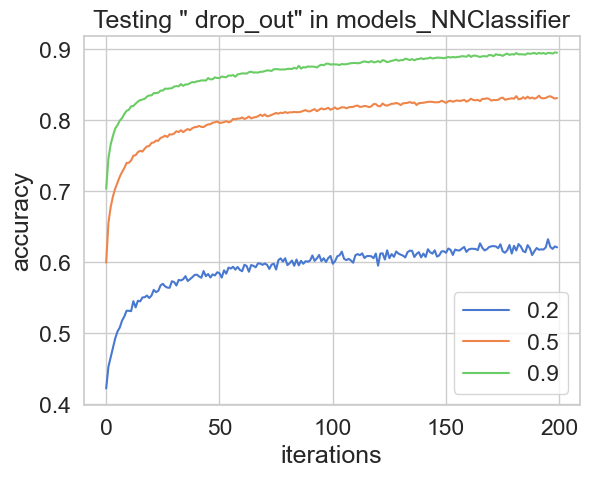

In [224]:
drop_out = [0.2, 0.5, 0.9]
legend = ["0.2", "0.5", "0.9"]

models_NNClassifier = {}
for i in drop_out:
    models_NNClassifier[str(i)] = NNClassifier(n_classes=N_CLASSES, n_features=N_FEATURES,  n_hidden_units=50, l2=0.5, l1=0.0, epochs=200, learning_rate=0.01,batch_size=1000, keep_prob=i, random_seed=RANDOM_SEED).fit(X_train, y_train)
    plt.plot(range(len(models_NNClassifier[str(i)].score_)), models_NNClassifier[str(i)].score_)
plt.legend(legend, loc='best')
plt.title('Testing " drop_out" in models_NNClassifier')
plt.ylabel('accuracy')
plt.xlabel('iterations')
plt.show()


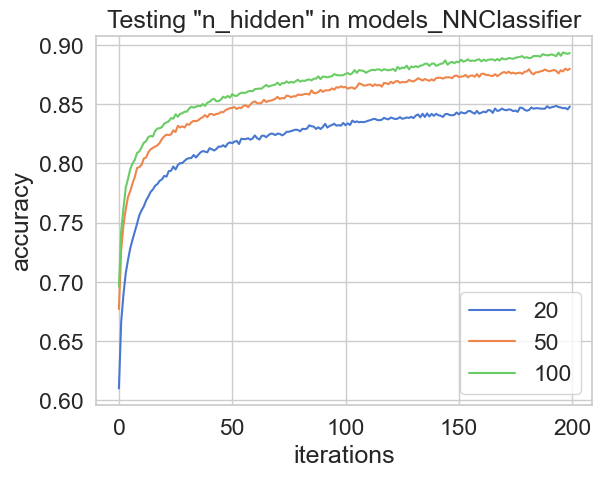

In [225]:
n_hidden = [20, 50, 100]
legend = ["20", "50", "100"]

models_NNClassifier = {}
for i in n_hidden:
    models_NNClassifier[str(i)] = NNClassifier(n_classes=N_CLASSES, n_features=N_FEATURES,  n_hidden_units=i, l2=0.5, l1=0.0, epochs=200, learning_rate=0.01,batch_size=1000, keep_prob=0.8, random_seed=RANDOM_SEED).fit(X_train, y_train)
    plt.plot(range(len(models_NNClassifier[str(i)].score_)), models_NNClassifier[str(i)].score_)
plt.legend(legend, loc='best')
plt.title('Testing "n_hidden" in models_NNClassifier')
plt.ylabel('accuracy')
plt.xlabel('iterations')
plt.show()
